# Multilayer Perception implemented in numpy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import pandas as pd


/tmp/ipykernel_40537/3001837380.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
x, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')

In [8]:
y.to_numpy().astype(int)

array([5, 0, 4, ..., 4, 5, 6])

In [9]:


DIMENSIONS = (28, 28)
CHANNELS = 1  # grayscale
INPUT_SIZE = DIMENSIONS[0] * DIMENSIONS[1]
OUTPUT_SIZE = 10

def transform_data(
        is_convolutional: bool,
        x: pd.DataFrame,
        y: pd.Series | None = None) -> tuple[np.array, np.array]:
    """
    Transforms the data. Returns a tuple of (x, y) where x is a tensor of the features and y is a
    tensor of the labels.

    Args:
        is_convolutional: A boolean indicating whether the model is convolutional.
        x: A dataframe of the features.
        y: A series of the labels.
    """
    x = x.to_numpy()
    # Normalize the tensor
    x_min = x.min()
    x_max = x.max()
    x = (x - x_min) / (x_max - x_min)
    assert x.min() == 0
    assert x.max() == 1
    if is_convolutional:
        # Reshape data to have channel dimension
        # MNIST images are 28x28, so we reshape them to [batch_size, 1, 28, 28]
        x = x.reshape(-1, CHANNELS, DIMENSIONS[0], DIMENSIONS[1])
    if y is not None:
        y = y.to_numpy().astype(int)
    return x, y


def get_data():  # noqa
    """Function is required by and called from `model_pipeline()`."""
    x, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')
    x, y = transform_data(is_convolutional=False, x=x, y=y)
    # 80% train; 10% validation; 10% test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)
    print(f"Training set  : X-{x_train.shape}, y-{y_train.shape}")
    print(f"Validation set: X-{x_val.shape}, y-{y_val.shape}")
    print(f"Test set      : X-{x_test.shape}, y-{y_test.shape}")
    return x_train, x_val, x_test, y_train, y_val, y_test

x_train, x_val, x_test, y_train, y_val, y_test = get_data()

Training set  : X-(56000, 784), y-(56000,)
Validation set: X-(7000, 784), y-(7000,)
Test set      : X-(7000, 784), y-(7000,)


In [13]:
x_train.shape

(56000, 784)

In [14]:
y.shape

(70000,)

In [15]:
y[0:10]

0    5
1    0
2    4
3    1
4    9
5    2
6    1
7    3
8    1
9    4
Name: class, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

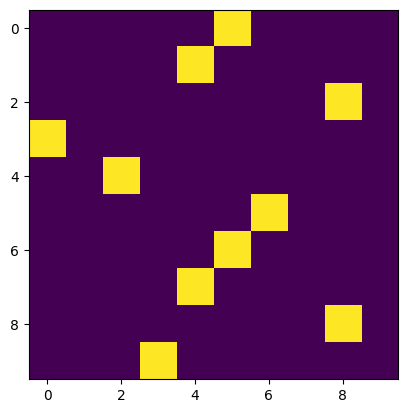

In [20]:
# encode
def one_hot_encode(index: int) -> np.array:
    """Return a one-hot encoded vector of the given index."""
    vector = np.zeros(OUTPUT_SIZE)
    vector[index] = 1
    return vector

y_train = np.array([one_hot_encode(i) for i in y_train])
plt.imshow(y_train[0:10])

In [21]:
def relu(z: np.array) -> np.array:
    """Return the ReLU of the input."""
    return np.maximum(0, z)

def relu_derivative(z: np.array) -> np.array:
    """Return the derivative of the ReLU of the input."""
    return (z > 0).astype(float)

def softmax(x: np.array) -> np.array:
    """
    Return the softmax of the input.

    The softmax function is a generalization of the logistic function that "squashes" a
    K-dimensional
    vector z of arbitrary real values to a K-dimensional vector sigma(z) of real values in the
    range (0, 1) that add up to 1.

    In other words, the softmax function transforms a vector of real values into a probability
    distribution.
    """
    exp_x = np.exp(x)
    return exp_x / exp_x.sum(axis=1).reshape(-1, 1)

def forward_pass(x: np.array, params: dict) -> tuple[np.array, dict]:
    """
    Return the output of a forward pass through the network, as well as the cache.

    The cache contains the pre-activations and activations for each layer.
    """
    W_1 = params["W_1"]
    b_1 = params["b_1"]
    W_2 = params["W_2"]
    b_2 = params["b_2"]
    Z_1 = (x @ W_1) + b_1  # pre-activations for layer 1
    A_1 = relu(Z_1)  # activations for layer 1
    Z_2 = (A_1 @ W_2) + b_2  # pre-activations for layer 2
    # A_Z is refered to as "logits"
    A_2 = softmax(Z_2)  # activations for layer 2 are probabilities
    cache = {
        "Z_1": Z_1,
        "A_1": A_1,
        "Z_2": Z_2,
        "A_2": A_2,
    }
    return A_2, cache

def backward_pass(x: np.array, y: np.array, params: dict, cache: dict) -> dict:
    """
    Return the gradients of the loss w.r.t. the parameters of the network.

    The gradients are computed using backpropagation.
    """
    m = x.shape[0]
    W_2 = params['W_2']
    A_1 = cache['A_1']
    A_2 = cache['A_2']
    Z_1 = cache['Z_1']
    # step 1: Gradients of loss w.r.t. pre-activations of layer 2
    dZ_2 = A_2 - y
    # Step 2: Gradients of loss w.r.t. W_2 and b_2
    dW_2 = (A_1.T @ dZ_2) / m
    db_2 = np.sum(dZ_2, axis=0, keepdims=True) / m
    # Step 3: Backpropagation through ReLU activation
    dA_1 = dZ_2 @ W_2.T
    dZ_1 = dA_1 * relu_derivative(Z_1)
    # Step 4: Gradients of loss w.r.t. W_1 and b_1
    dW_1 = x.T @ dZ_1 / m
    db_1 = np.sum(dZ_1, axis=0, keepdims=True) / m
    return {
        "dW_1": dW_1,
        "db_1": db_1,
        "dW_2": dW_2,
        "db_2": db_2,
    }

def update_parameters(params, grads, learning_rate):
    params['W_1'] -= learning_rate * grads['dW_1']
    params['b_1'] -= learning_rate * grads['db_1']
    params['W_2'] -= learning_rate * grads['dW_2']
    params['b_2'] -= learning_rate * grads['db_2']
    return params

def compute_loss(pred_probs: np.array, y: np.array) -> float:
    row_indices = np.arange(y.shape[0])
    column_indices = np.argmax(y, axis=1)
    pred_prob_of_actual = pred_probs[row_indices, column_indices]
    return -np.log(pred_prob_of_actual + 1e-9).mean()

In [22]:
seed = 42
rng = np.random.default_rng(seed)

input_size = 28 * 28
hidden_size = 100
output_size = 10

# He initialization for weights (with ReLU activation)
he_scale = np.sqrt(2 / hidden_size)

W_1 = rng.normal(loc=0, scale=he_scale, size=(input_size, hidden_size))
b_1 = np.zeros((1, hidden_size))
W_2 = rng.normal(loc=0, scale=he_scale, size=(hidden_size, output_size))
b_2 = np.zeros((1, output_size))

# I want to view the original weights vs trained weights
W_1_copy = W_1.copy()
W_2_copy = W_2.copy()

print(W_1.shape)
print(b_1.shape)
print(W_2.shape)
print(b_2.shape)

(784, 100)
(1, 100)
(100, 10)
(1, 10)


In [23]:
learning_rate = 0.01
epochs = 15
batch_size = 32
losses = []

params = {
    "W_1": W_1,
    "b_1": b_1,
    "W_2": W_2,
    "b_2": b_2,
}

for epoch in range(epochs):
    for i in range(0, x_train.shape[0], batch_size):
        x_batch = x_train[i:i+batch_size]
        y = y_train[i:i+batch_size]
        A2, cache = forward_pass(x_batch, params)
        loss = compute_loss(y=y, pred_probs=A2)
        grads = backward_pass(x_batch, y, params, cache)
        params = update_parameters(params, grads, learning_rate)
        if i % 6_400 == 0:
            losses.append(loss)
            print(f"Epoch {epoch}, batch {i:06}, loss {loss}")
print(f'Epoch {epoch}, Batch {i}, Loss: {loss.item()}')

Epoch 0, batch 000000, loss 2.774688085358225


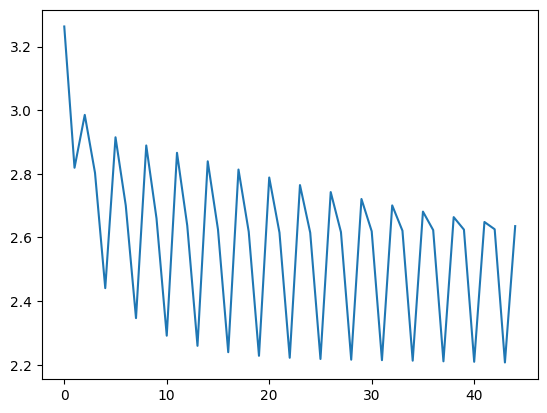

In [11]:
# plot losses over time
plt.plot(losses)

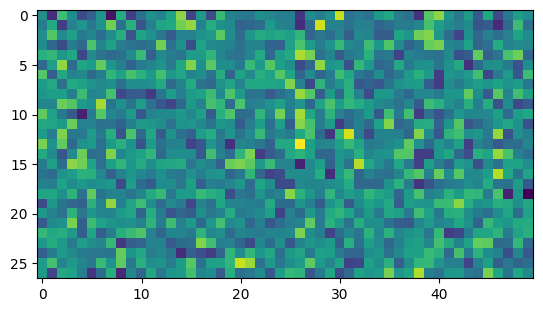

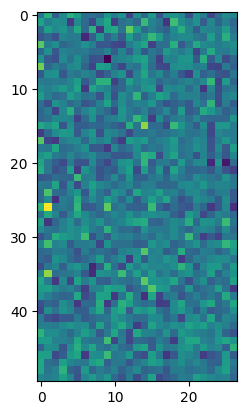

In [12]:
plt.imshow(W_1)
plt.show()
plt.imshow(W_2)
plt.show()

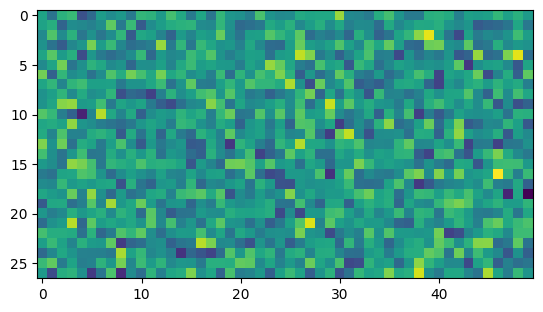

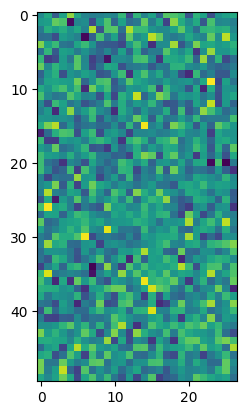

In [13]:
plt.imshow(W_1_copy)
plt.show()
plt.imshow(W_2_copy)
plt.show()